# Section 5.4 — Bayesian linear models

This notebook contains the code examples from [Section 5.4 Bayesian linear models]() from the **No Bullshit Guide to Statistics**.

See also examples in:
- [BambiRegression.ipynb](./explorations/BambiRegression.ipynb).
- [chp_03.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_03.ipynb)
- [ESCS_multiple_regression.ipynb](./explorations/bambi/ESCS_multiple_regression.ipynb)
- [bayesian regression in numpyro](https://nbviewer.org/github/pyro-ppl/numpyro/blob/master/notebooks/source/bayesian_regression.ipynb)
- Bambi demos: [01_multiple_linear_regression.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/bambi-paper-main/original/01_multiple_linear_regression.ipynb)
  and [02_logistic_regression.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/bambi-paper-main/original/02_logistic_regression.ipynb)
- [econmt_bayes_bambi.ipynb](./explorations/econmt_bayes_bambi.ipynb)

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import bambi as bmb
import numpy as np
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (9, 5)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayes/lms"
#######################################################

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)

In [4]:
# silence statsmodels kurtosistest warning when using n < 20
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Model

## Example 1: students score as a function of effort

In [5]:
students = pd.read_csv("../datasets/students.csv")
# students.head()

In [6]:
# sns.scatterplot(x="effort", y="score", data=students);

In [7]:
# priors1 = {
#     "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
#     "x": bmb.Prior("Normal", mu=0, sigma=10),
#     "sigma": bmb.Prior("HalfNormal", sigma=1),
# }
priors1 = None

mod1 = bmb.Model("score ~ 1 + effort",
                 priors=priors1,
                 data=students)
print(mod1)

idata1 = mod1.fit()

       Formula: score ~ 1 + effort
        Family: gaussian
          Link: mu = identity
  Observations: 15
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 72.58, sigma: 116.553)
            effort ~ Normal(mu: 0.0, sigma: 12.8061)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 9.6409)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, effort]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [8]:
az.summary(idata1, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,32.680,6.861,19.996,45.226
effort,4.485,0.754,3.130,5.947
sigma,5.333,1.157,3.446,7.389


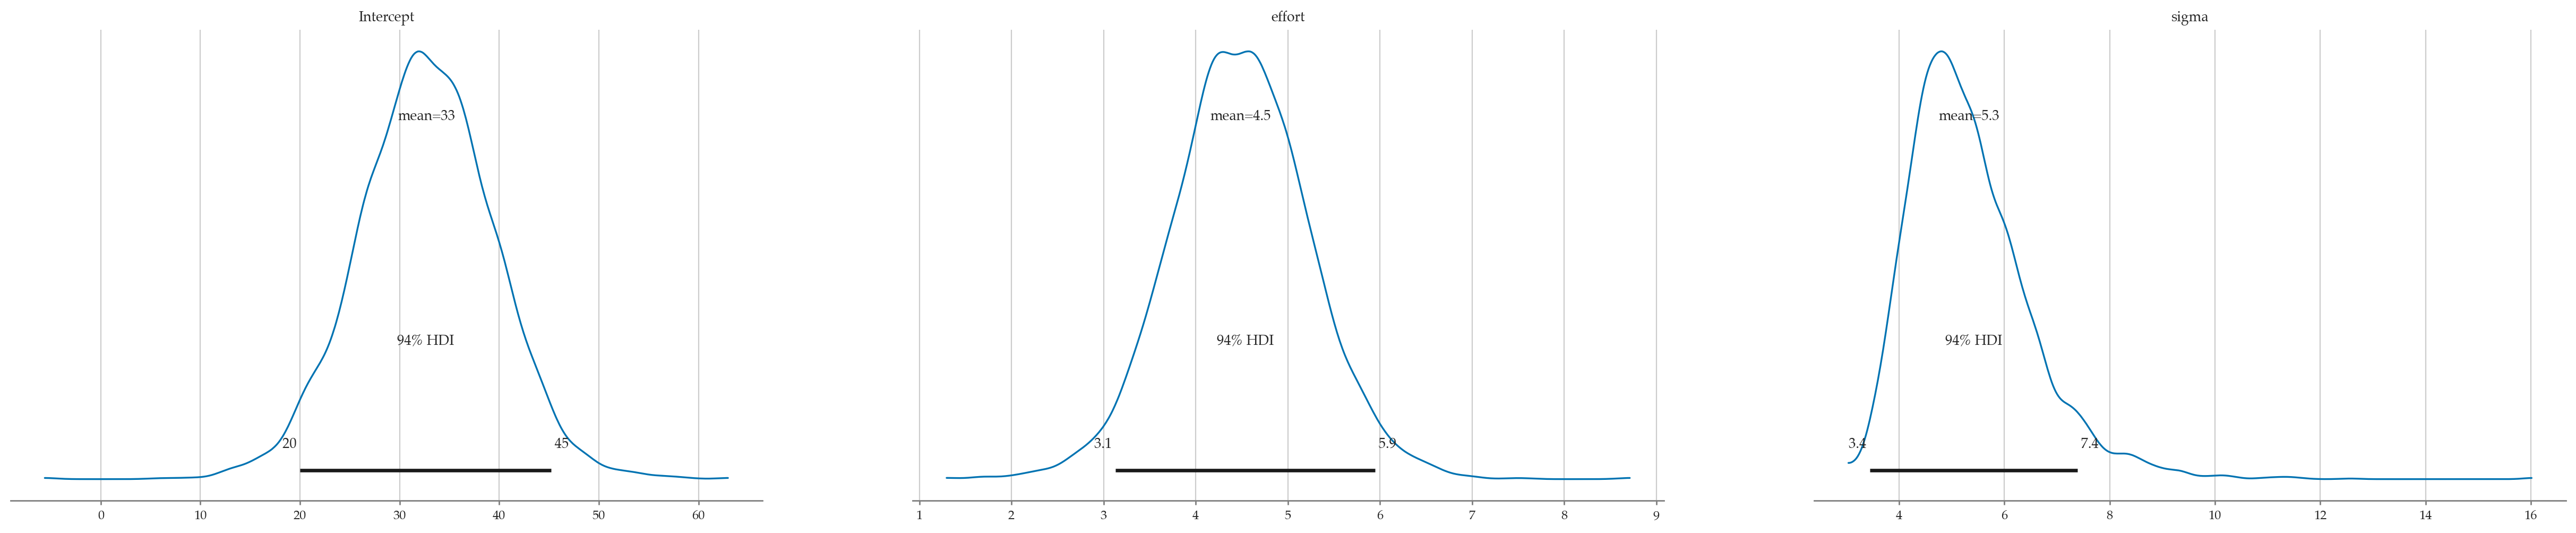

In [9]:
az.plot_posterior(idata1);

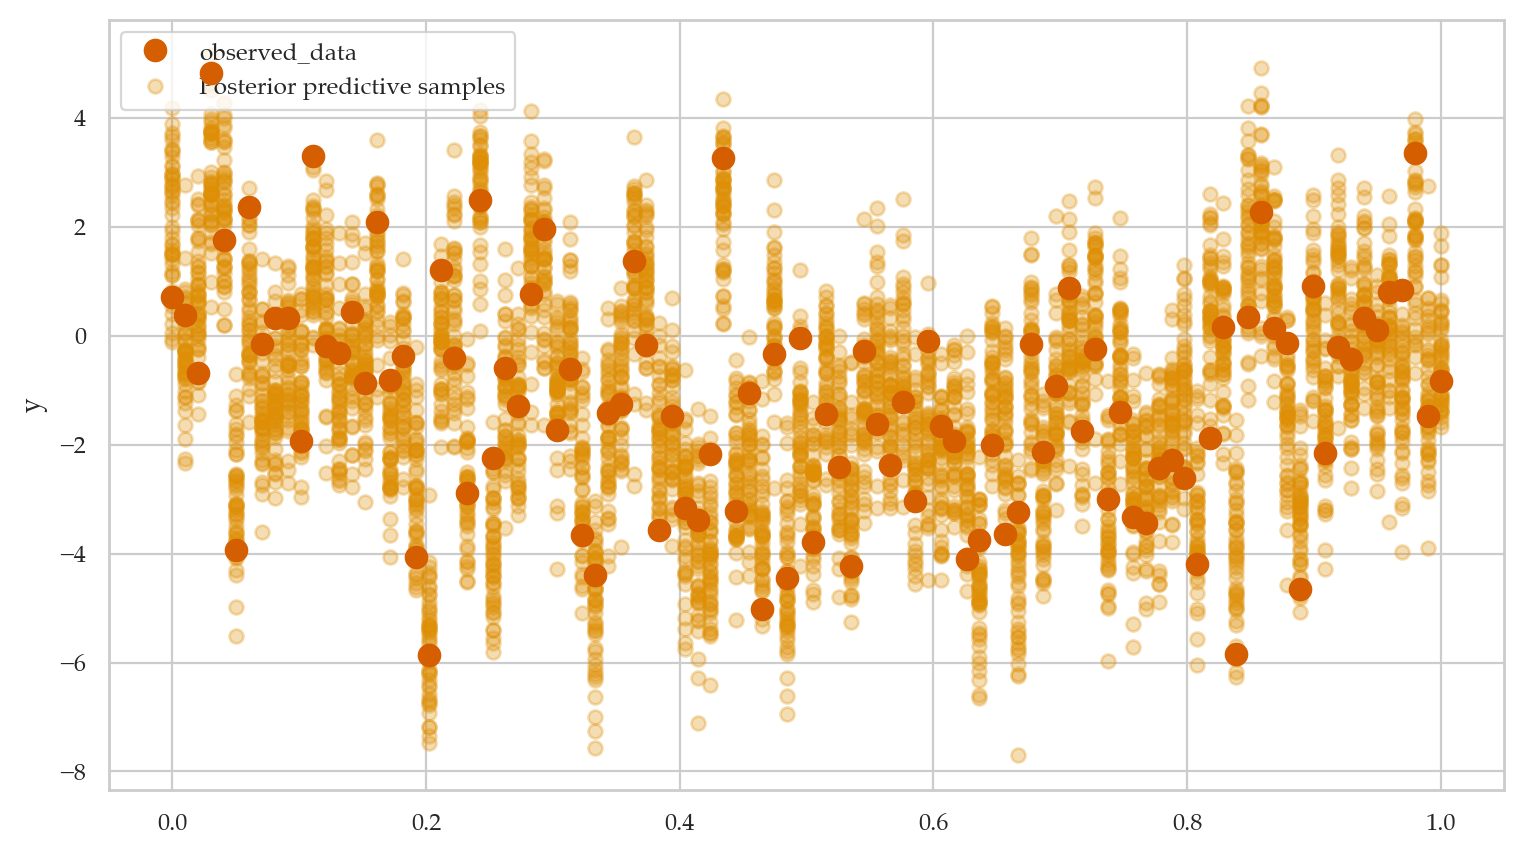

In [10]:
import xarray as xr
idata = az.load_arviz_data('regression1d')
x = xr.DataArray(np.linspace(0, 1, 100))
idata.posterior["y_model"] = idata.posterior["intercept"] + idata.posterior["slope"]*x
az.plot_lm(idata=idata, y="y", x=x);

In [11]:
# az.plot_ppc(idata2_rep, group="posterior")

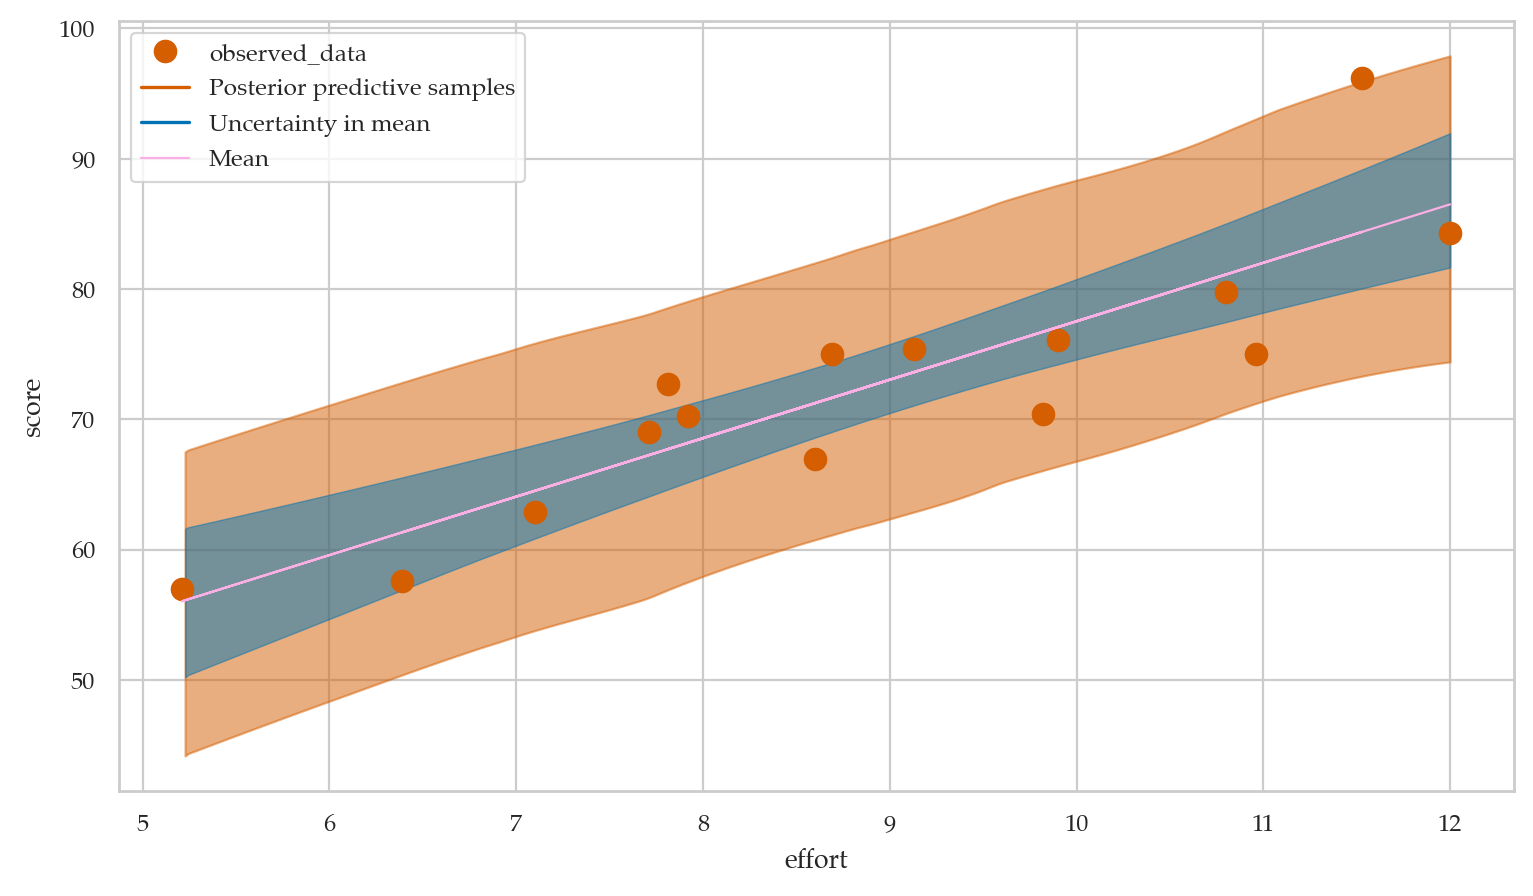

In [12]:
import xarray as xr

# Generate samples form the posterior predictive distribution
mod1.predict(idata1, kind="response")

# Calculate the model mean
post1 = idata1["posterior"]
efforts = students["effort"]
post1["score_model"] = post1["Intercept"] + post1["effort"] * xr.DataArray(efforts)

# Plot
# az.plot_lm(y="score", idata=idata1, x=efforts);
# az.plot_lm(y="score", idata=idata1, y_model="score_pred", x=efforts);
az.plot_lm(y="score", idata=idata1, y_model="score_model", x=efforts, kind_pp="hdi", kind_model="hdi");

In [13]:
# compare with statsmodels results
import statsmodels.formula.api as smf
smf.ols("score ~ 1 + effort", data=students).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,32.4658,6.155,5.275,0.000,19.169,45.763
effort,4.5049,0.676,6.661,0.000,3.044,5.966


## Example 2: doctors sleep scores

In [14]:
doctors = pd.read_csv("../datasets/doctors.csv")
# doctors.shape

In [15]:
# priors2 = {
#     "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
#     "x": bmb.Prior("Normal", mu=0, sigma=10),
#     "sigma": bmb.Prior("HalfNormal", sigma=1),
# }
priors2 = None

mod2 = bmb.Model("score ~ 1 + alc + weed + exrc",
                 priors=priors2,
                 data=doctors)
print(mod2)

idata2 = mod2.fit()

       Formula: score ~ 1 + alc + weed + exrc
        Family: gaussian
          Link: mu = identity
  Observations: 156
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 48.0256, sigma: 102.6936)
            alc ~ Normal(mu: 0.0, sigma: 5.4214)
            weed ~ Normal(mu: 0.0, sigma: 36.7457)
            exrc ~ Normal(mu: 0.0, sigma: 10.6572)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3807)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, alc, weed, exrc]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [16]:
az.summary(idata2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,60.449,1.286,58.070,62.793
alc,-1.800,0.071,-1.930,-1.667
exrc,1.767,0.138,1.512,2.026
sigma,8.266,0.475,7.424,9.191
weed,-1.016,0.485,-1.921,-0.114


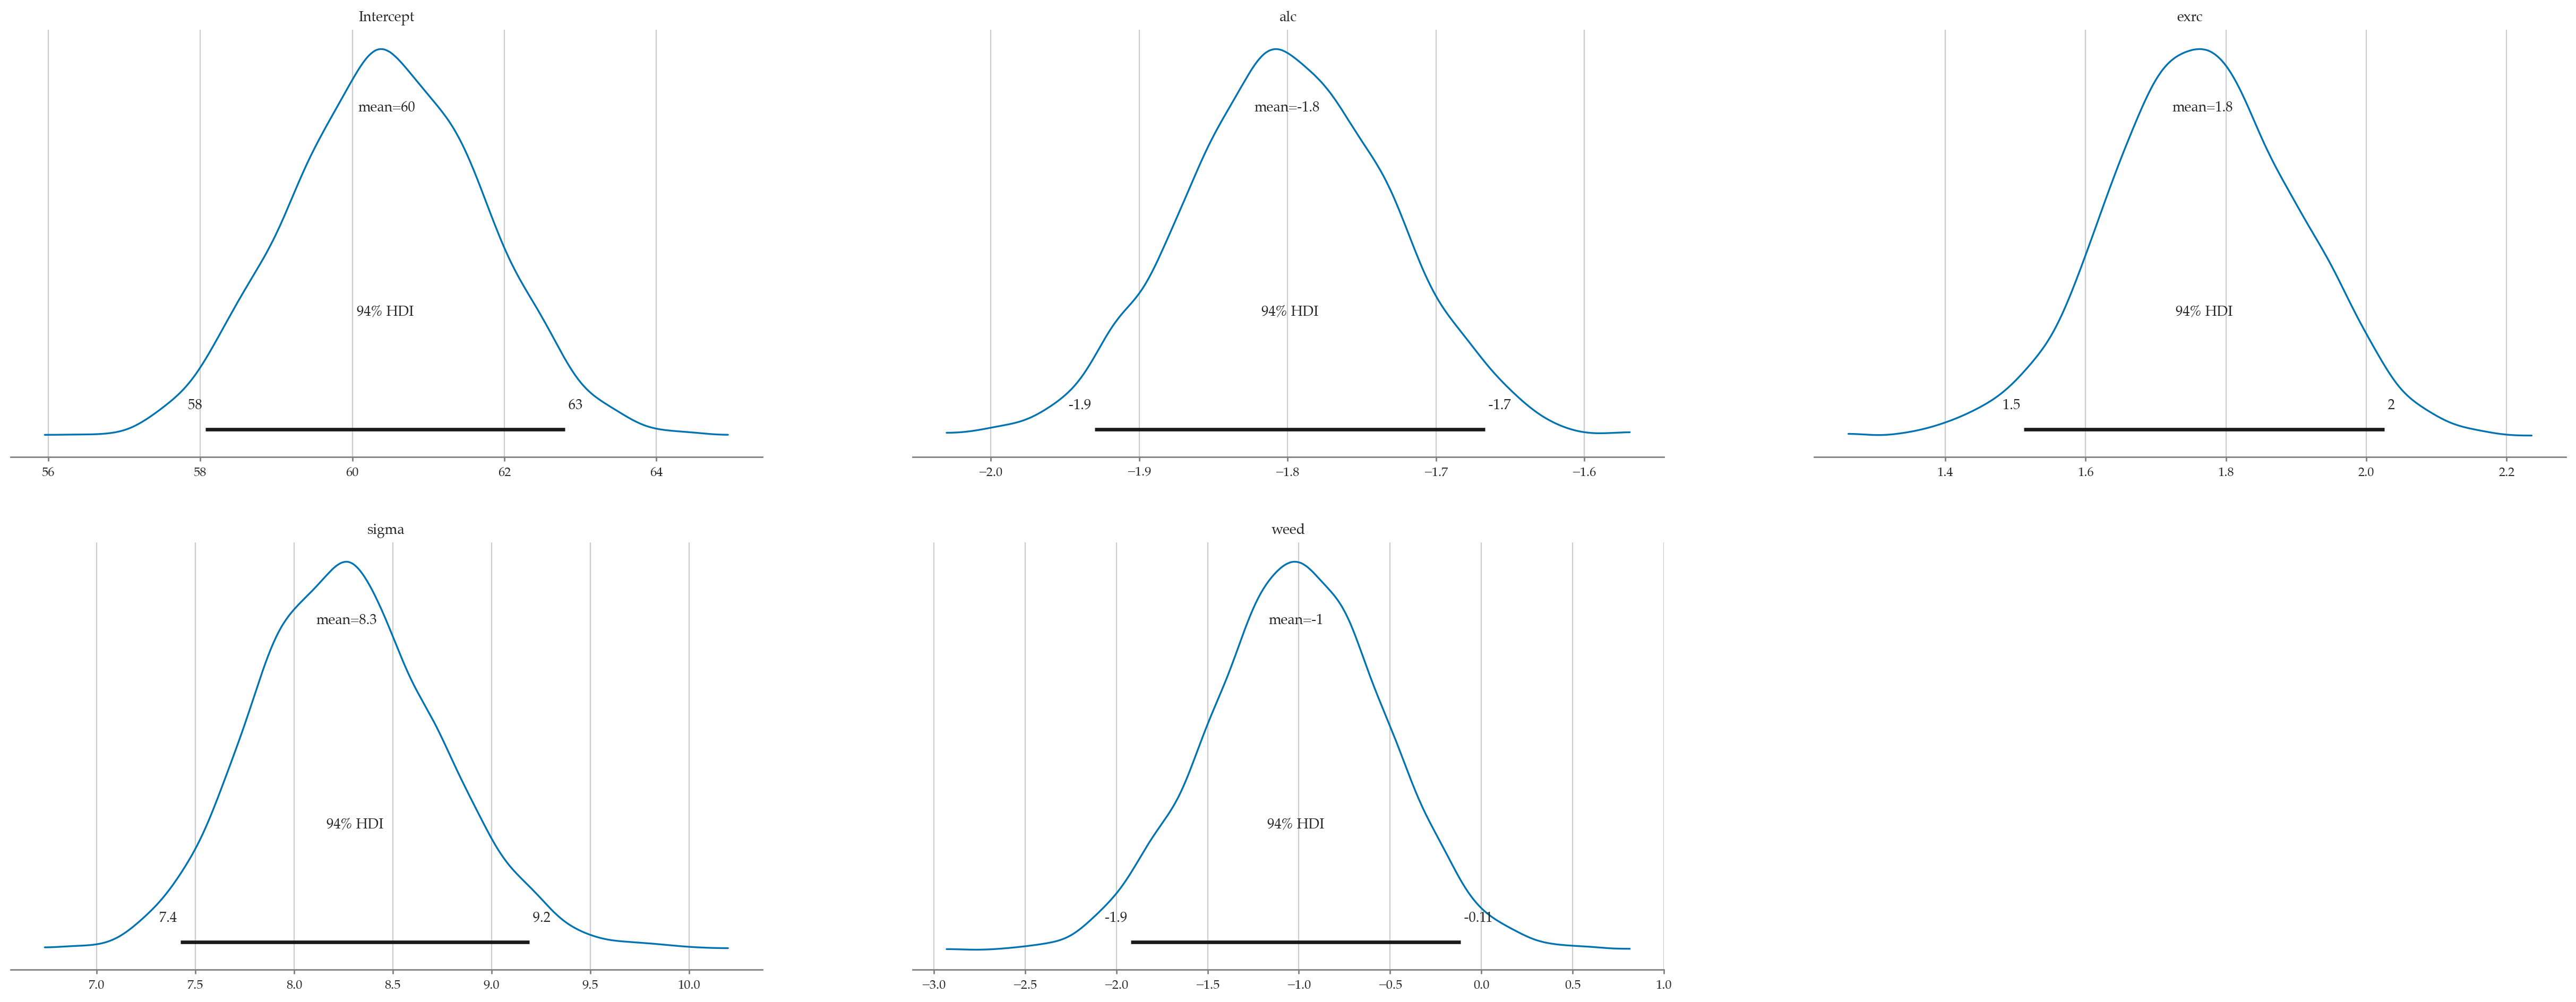

In [17]:
az.plot_posterior(idata2);

In [18]:
# compare with statsmodels results
import statsmodels.formula.api as smf
formula = "score ~ 1 + alc + weed + exrc"
smf.ols(formula, data=doctors).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,60.4529,1.289,46.885,0.000,57.905,63.000
alc,-1.8001,0.070,-25.726,0.000,-1.938,-1.662
weed,-1.0216,0.476,-2.145,0.034,-1.962,-0.081
exrc,1.7683,0.138,12.809,0.000,1.496,2.041


## Example 3: Bayesian logistic regression

via [file:///Users/ivan/Downloads/talks-main/pydataglobal21/index.html#15](/Users/ivan/Downloads/talks-main/pydataglobal21/index.html#15)

via https://github.com/tomicapretto/talks/blob/main/pydataglobal21/index.Rmd#L123

In [19]:
import bambi as bmb
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [20]:
model = bmb.Model("vote[clinton] ~ 0 + party_id + party_id:age", data, family="bernoulli")
print(model)

idata = model.fit()

Modeling the probability that vote==clinton


       Formula: vote[clinton] ~ 0 + party_id + party_id:age
        Family: bernoulli
          Link: p = logit
  Observations: 421
        Priors: 
    target = p
        Common-level effects
            party_id ~ Normal(mu: [0. 0. 0.], sigma: [1. 1. 1.])
            party_id:age ~ Normal(mu: [0. 0. 0.], sigma: [0.0586 0.0586 0.0586])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [party_id, party_id:age]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [21]:
import pandas as pd
new_subjects = pd.DataFrame({"age": [20, 60], "party_id": ["independent"] * 2})
model.predict(idata, data=new_subjects)

# TODO: try to repdouce 
# https://github.com/tomicapretto/talks/blob/main/pydataglobal21/index.Rmd#L181-L193

## Explanations

## Discussion

## Exercises

### Exercise: bioassay logistic regression

Gelman et al. (2003) present an example of an acute toxicity test, commonly performed on animals to estimate the toxicity of various compounds.

In this dataset `log_dose` includes 4 levels of dosage, on the log scale, each administered to 5 rats during the experiment. The response variable is death, the number of positive responses to the dosage.

The number of deaths can be modeled as a binomial response, with the probability of death being a linear function of dose:

$$\begin{aligned}
y_i &\sim \text{Bin}(n_i, p_i) \\
\text{logit}(p_i) &= a + b x_i
\end{aligned}$$

The common statistic of interest in such experiments is the LD50, the dosage at which the probability of death is 50%.


via https://github.com/fonnesbeck/pymc_sdss_2024/blob/main/notebooks/Section2-PyMC_Intro.ipynb





In [22]:
# Log dose in each group
log_dose = [-.86, -.3, -.05, .73]

# Sample size in each group
n = 5

# Outcomes
deaths = [0, 1, 3, 5]

In [23]:
# SOLUTION
import pymc as pm

invlogit = pm.math.invlogit

with pm.Model() as bioassay:
    a = pm.Normal('a', 0, 5)
    b = pm.Normal('b', 0, 5)
    p = invlogit(a + b*np.array(log_dose))
    y = pm.Binomial('y', n=n, p=p, observed=np.array(deaths))
    LD50 = pm.Deterministic('LD50', -a/b)
    bioassay_idata = pm.sample()

import arviz as az
az.summary(bioassay_idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
LD50,-0.076,0.139,-0.313,0.217,0.003,0.002,2163.0,2215.0,1.0
a,0.555,0.795,-0.898,2.103,0.020,0.014,1646.0,1828.0,1.0
b,6.349,2.565,1.889,11.003,0.063,0.046,1695.0,1925.0,1.0


## Links

## BONUS MATERIAL

## Simple linear regression on synthetic data

In [24]:
# Simulated data
np.random.seed(42)
x = np.random.normal(0, 1, 100)
y = 3 + 2 * x + np.random.normal(0, 1, 100)

In [25]:
df1 = pd.DataFrame({"x":x, "y":y})

priors1 = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
    "x": bmb.Prior("Normal", mu=0, sigma=10),
    "sigma": bmb.Prior("HalfNormal", sigma=1),
}

model1 = bmb.Model("y ~ 1 + x",
                   priors=priors1,
                   data=df1)
print(model1)

idata = model1.fit()

       Formula: y ~ 1 + x
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.0)
            x ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Sampling: [Intercept, sigma, x]


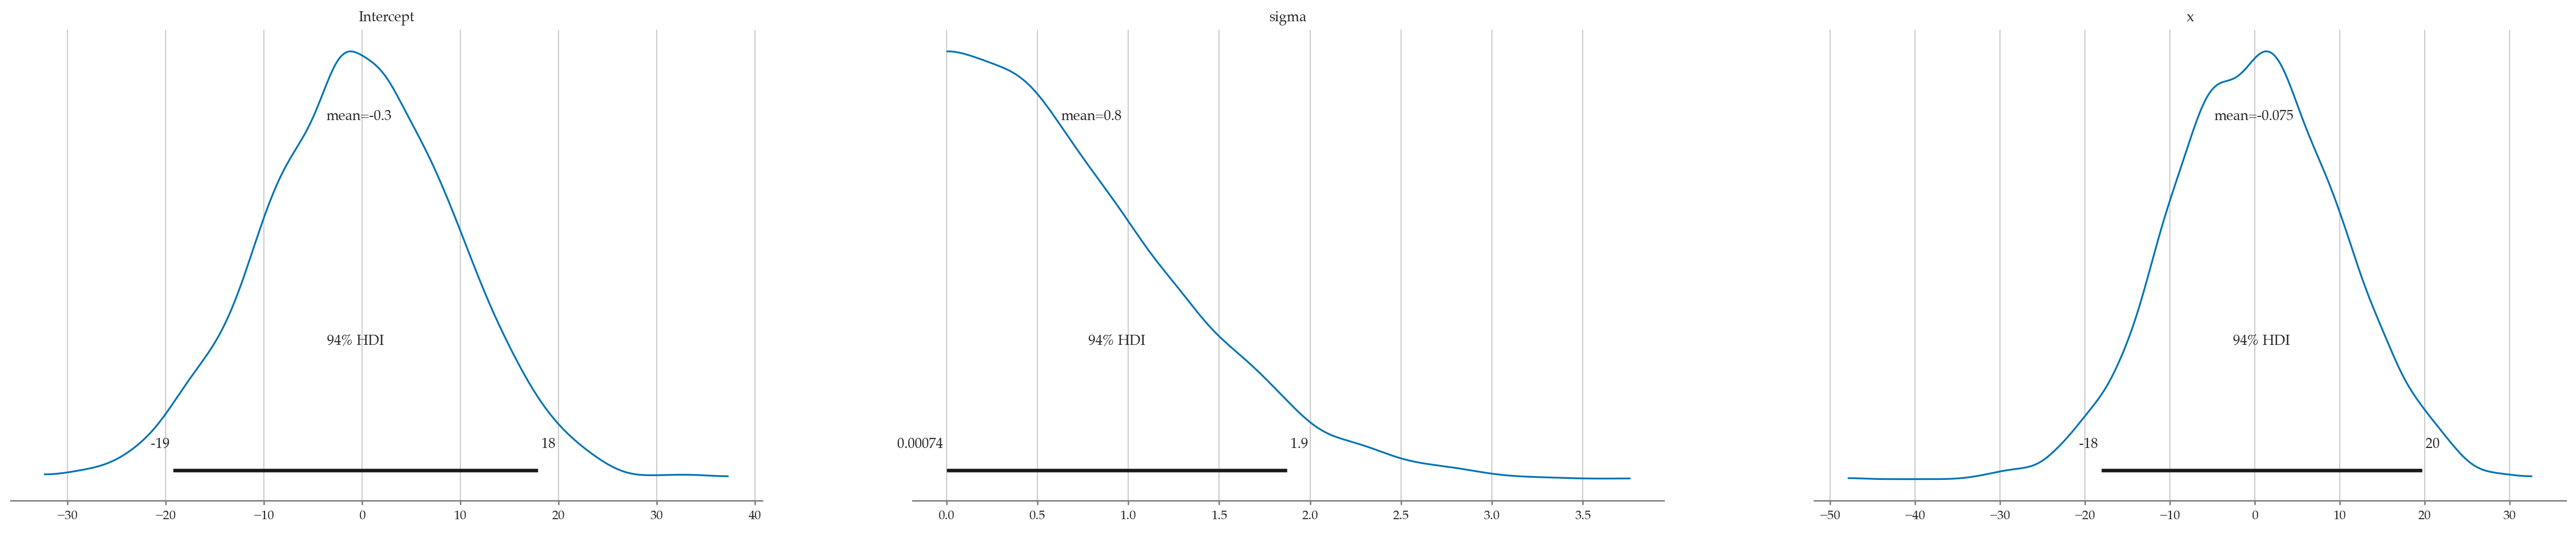

In [26]:
model1.plot_priors();

### Summary using mean


In [27]:
# Posterior Summary
summary = az.summary(idata, kind="stats")
summary

,mean,sd,hdi_3%,hdi_97%
Intercept,3.008,0.097,2.830,3.193
sigma,0.957,0.067,0.829,1.079
x,1.856,0.105,1.666,2.057


### Summary using median as focus statistic

ETI = Equal-Tailed Interval

In [28]:
az.summary(idata, stat_focus="median", kind="stats")

,median,mad,eti_3%,eti_97%
Intercept,3.005,0.067,2.831,3.195
sigma,0.953,0.046,0.839,1.091
x,1.858,0.071,1.659,2.052


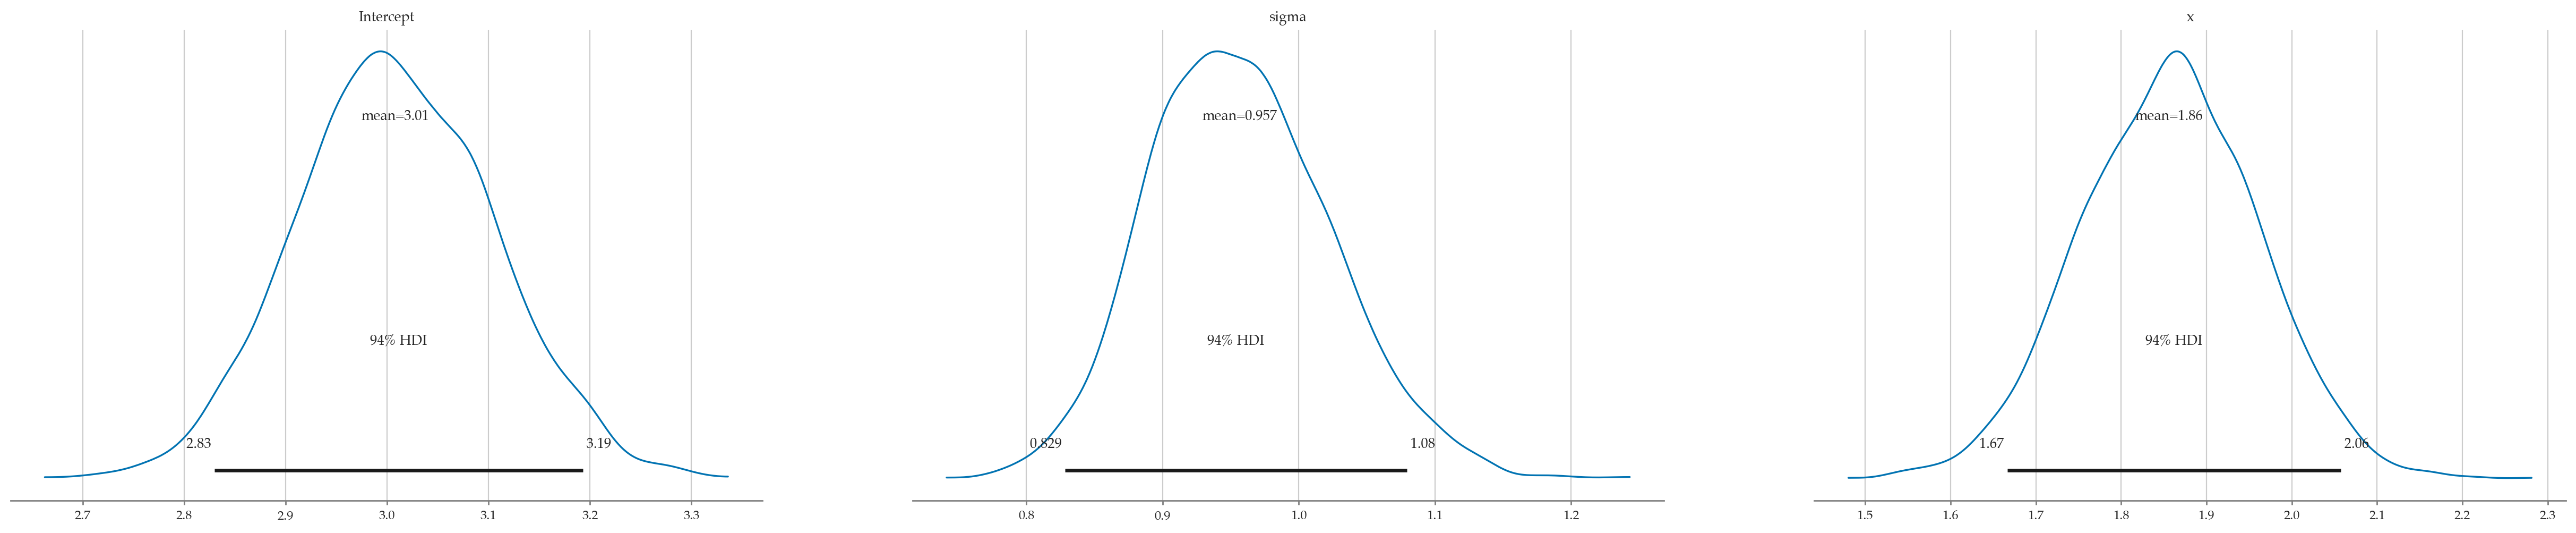

In [29]:
# Plotting posterior
az.plot_posterior(idata, point_estimate="mean", round_to=3);

Investigare further

https://python.arviz.org/en/latest/api/generated/arviz.plot_lm.html

In [30]:
# az.plot_lm(idata)

### Simple linear regression using PyMC

In [31]:
import pymc as pm

In [32]:
# Simulated data
np.random.seed(42)
x = np.random.normal(0, 1, 100)
y = 3 + 2 * x + np.random.normal(0, 1, 100)

In [33]:
# Bayesian Linear Regression Model
with pm.Model() as pmmodel:
    # Priors
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Likelihood
    mu = beta0 + beta1 * x
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    # Sampling
    idata = pm.sample()

az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,3.007,0.094,2.830,3.180,0.001,0.001,5671.0,3088.0,1.0
beta1,1.859,0.105,1.667,2.064,0.001,0.001,6005.0,3290.0,1.0
sigma,0.956,0.068,0.837,1.086,0.001,0.001,5310.0,2831.0,1.0
